# 시계열 예측 모델

Sequence (시계열) 데이터 다루기

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

**금융 데이터**를 활용한 시계열 데이터 예측

Finance DataReader를 활용하여 시계열 데이터를 로드하고 금융 데이터를 예측합니다.

## 필요한 모듈 import

In [1]:
import csv
import tensorflow as tf
import numpy as np
import urllib
import pandas as pd

# module import
from tensorflow.keras.layers import Dense, LSTM, GRU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


## Finace DataReader

[링크](https://github.com/FinanceData/FinanceDataReader)

In [2]:
# 데이터를 받아오기 위해 finance-datareader 모듈을 설치합니다.
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import FinanceDataReader as fdr

In [4]:
# 비트코인 시세를 가져옵니다.
data = fdr.DataReader('BTC/KRW')
data

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-05-23,3206000,3104000,3281000,3081000,21580.0,0.0329
2017-05-24,4175000,3206000,4314000,3206000,34680.0,0.3022
2017-05-25,4199000,4175000,4840000,3102000,35910.0,0.0057
2017-05-26,3227000,4199000,4200000,2900000,36650.0,-0.2315
2017-05-27,3152000,3227000,3288000,2460000,33750.0,-0.0232
...,...,...,...,...,...,...
2022-08-21,29471000,29350000,29641000,29009000,320.0,0.0041
2022-08-22,29236000,29461000,29553000,28811000,770.0,-0.0080
2022-08-23,29255000,29238000,29508000,28609000,480.0,0.0006


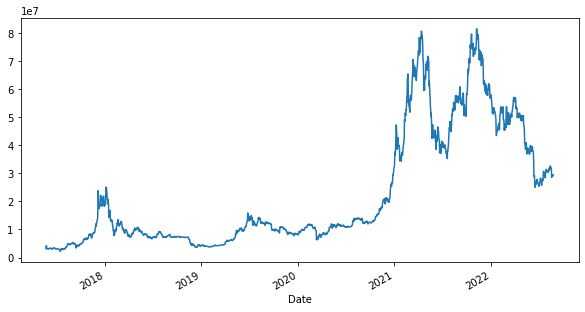

In [5]:
data['Close'].plot(figsize=(10, 5))

In [6]:
# 아래 컬럼의 데이터만 추출하여 최초 최대 정규화를 적용하세요.
# ['Open', 'High', 'Low', 'Close', 'Volume']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(data[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled

,Open,High,Low,Close,Volume
0,0.011237,0.011817,0.016351,0.012523,0.175837
1,0.012523,0.024706,0.017946,0.024744,0.282776
2,0.024744,0.031270,0.016619,0.025047,0.292816
3,0.025047,0.023284,0.014040,0.012788,0.298857
4,0.012788,0.011904,0.008424,0.011842,0.275184
...,...,...,...,...,...
1914,0.342246,0.340737,0.347293,0.343772,0.002286
1915,0.343646,0.339639,0.344766,0.340808,0.005959
1916,0.340833,0.339077,0.342187,0.341048,0.003592
1917,0.341048,0.341074,0.346118,0.338916,0.003265


## Train Set, Validation Set 생성

Train Set / Validation Set 를 분할 합니다.

- ~최근 500개: Train Set
- 최근 500개~: Valid Set

In [8]:
train = df_scaled.iloc[:-500]
valid = df_scaled.iloc[-500:]

In [9]:
train.shape, valid.shape

((1419, 5), (500, 5))

## Window Dataset Loader

`window_size`, `batch_size`, `shuffle_buffer`는 자유롭게 설정합니다.

In [10]:
# 윈도우 사이즈
window_size=20
# 배치 사이즈
batch_size = 32
# 셔플 사이즈
shuffle_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

`train_set`와 `validation_set`를 만듭니다.

In [12]:
train_set = windowed_dataset(train['Close'], 
                             window_size=window_size, 
                             batch_size=batch_size,
                             shuffle=True,
                             shuffle_buffer=shuffle_size)

validation_set = windowed_dataset(valid['Close'], 
                                  window_size=window_size,
                                  batch_size=1,
                                  shuffle=False,
                                  shuffle_buffer=shuffle_size)

## 모델 정의 (Sequential)

In [13]:
model = Sequential([
    GRU(16, input_shape=(window_size, 1)),
    Dense(16, activation="relu"),
    Dense(1),
])

모델의 구조 요약을 확인합니다.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                912       
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


## 컴파일 (compile)

**Optimizer**의 `learning_rate`을 별도 설정합니다.

In [15]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0005),
              metrics=["mse"])

## ModelCheckpoint: 체크포인트 생성

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [16]:
checkpoint_path = 'tmp_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)


## 학습 (fit)

In [17]:
model.fit(train_set, 
          validation_data=(validation_set), 
          epochs=30, 
          callbacks=[checkpoint],
          )

Epoch 1/30
     44/Unknown - 8s 5ms/step - loss: 0.0109 - mse: 0.0109
Epoch 1: val_loss improved from inf to 0.02969, saving model to tmp_checkpoint.ckpt
44/44 [==============================] - 10s 50ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015
Epoch 2: val_loss improved from 0.02969 to 0.00311, saving model to tmp_checkpoint.ckpt
44/44 [==============================] - 2s 35ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/30
41/44 [==========================>...] - ETA: 0s - loss: 2.5489e-04 - mse: 2.5489e-04
Epoch 3: val_loss improved from 0.00311 to 0.00096, saving model to tmp_checkpoint.ckpt
44/44 [==============================] - 2s 36ms/step - loss: 2.6212e-04 - mse: 2.6212e-04 - val_loss: 9.5937e-04 - val_mse: 9.5937e-04
Epoch 4/30
40/44 [==========================>...] - ETA: 0s - loss: 1.5891e-04 - mse: 1.5891e-04
Epoch 4: v

## 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

In [18]:
model.load_weights(checkpoint_path)

## 예측

In [19]:
result = model.predict(validation_set)

In [20]:
result.shape

(480, 1)

## 예측 데이터 시각화

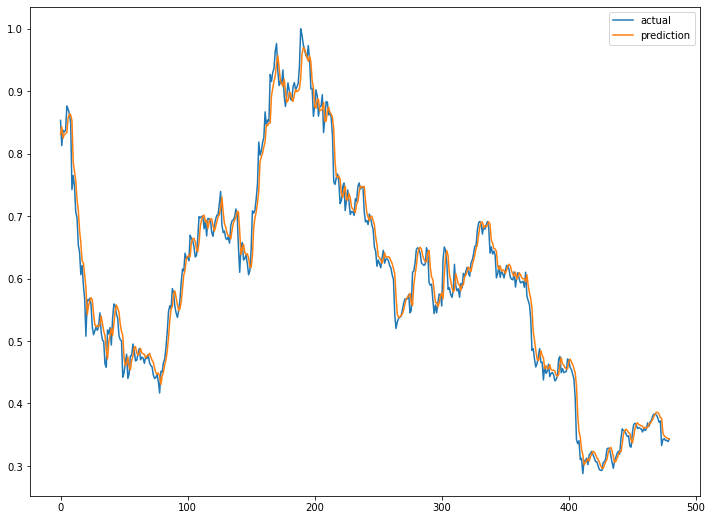

In [21]:
import matplotlib.pyplot as plt

# 테스트의 실제값과 예측값을 시각화 하세요.
plt.figure(figsize=(12, 9))
plt.plot(valid['Close'].iloc[window_size:].values, label='actual')
plt.plot(result.reshape(-1), label='prediction')
plt.legend()
plt.show()

In [25]:
yy = np.array(df_scaled['Close'].iloc[-22:-2]) 
yy = yy.reshape(1, 20, 1) 
model.predict(yy)

array([[0.34408173]], dtype=float32)

In [23]:
df_scaled

,Open,High,Low,Close,Volume
0,0.011237,0.011817,0.016351,0.012523,0.175837
1,0.012523,0.024706,0.017946,0.024744,0.282776
2,0.024744,0.031270,0.016619,0.025047,0.292816
3,0.025047,0.023284,0.014040,0.012788,0.298857
4,0.012788,0.011904,0.008424,0.011842,0.275184
...,...,...,...,...,...
1914,0.342246,0.340737,0.347293,0.343772,0.002286
1915,0.343646,0.339639,0.344766,0.340808,0.005959
1916,0.340833,0.339077,0.342187,0.341048,0.003592
1917,0.341048,0.341074,0.346118,0.338916,0.003265
